Current directory: /home/wzs/project/sionna-main/comcloak/training
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.7275e-01 | 1.0000e+00 |       24299 |       89088 |          128 |         128 |         3.6 |reached target block errors
     -4.5 | 2.5220e-01 | 1.0000e+00 |       22468 |       89088 |          128 |         128 |         3.5 |reached target block errors
     -4.0 | 2.1261e-01 | 1.0000e+00 |       18941 |       89088 |          128 |         128 |         3.5 |reached target block errors
     -3.5 | 1.4504e-01 | 9.7656e-01 |       12921 |       89088 |          125 |         128 |         3.6 |reached target block errors
     -3.0 | 5.5249e-02 | 7.0312e-01 |        9844 |      178176 |          180 |         256 |         7.0 |reached target block error

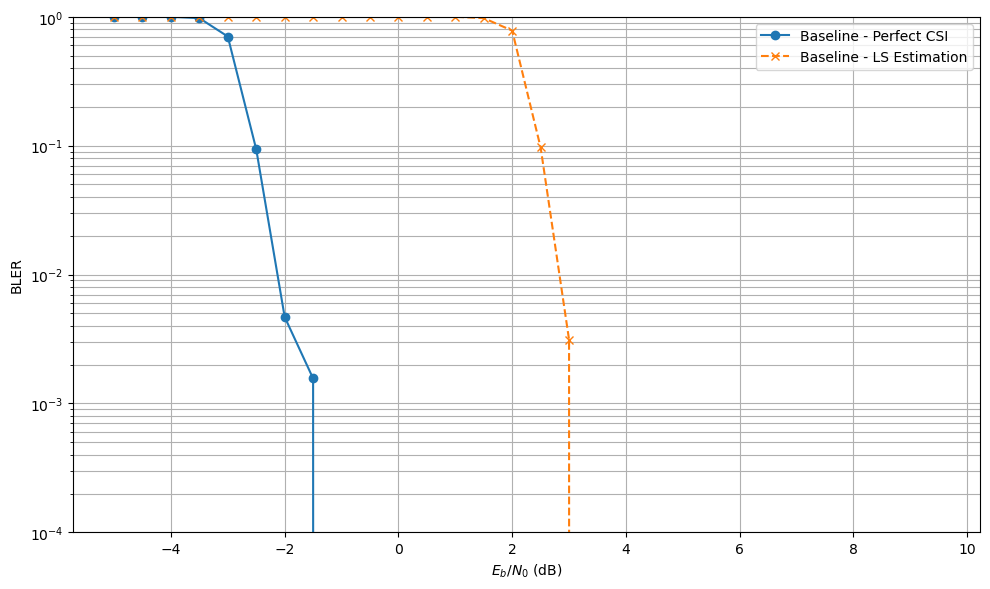

In [3]:
import os
gpu_num = 1 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import os
print("Current directory:", os.getcwd())
import sys
sys.path.append("./")
import sionna
# Load the required sionna components
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
from sionna.channel.tr38901 import Antenna, AntennaArray, CDL
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber

import tensorflow as tf
from tensorflow.keras import Model
############################################
## Channel configuration
NUM_BS_ANT = 2
carrier_frequency = 3.5e9 # Hz
delay_spread = 100e-9 # s
cdl_model = "C" # CDL model to use
speed = 10.0 # Speed for evaluation and training [m/s]
# SNR range for evaluation and training [dB]
ebno_db_min = -5.0
ebno_db_max = 10.0

############################################
## OFDM waveform configuration
subcarrier_spacing = 30e3 # Hz
fft_size = 128 # Number of subcarriers forming the resource grid, including the null-subcarrier and the guard bands
num_ofdm_symbols = 14 # Number of OFDM symbols forming the resource grid
dc_null = True # Null the DC subcarrier
num_guard_carriers = [5, 6] # Number of guard carriers on each side
pilot_pattern = "kronecker" # Pilot pattern
pilot_ofdm_symbol_indices = [2, 11] # Index of OFDM symbols carrying pilots
cyclic_prefix_length = 0 # Simulation in frequency domain. This is useless

############################################
## Modulation and coding configuration
num_bits_per_symbol = 2 # QPSK
coderate = 0.25 # Coderate for LDPC code (0.2, 0.95)
stream_manager = StreamManagement(np.array([[1]]), # Receiver-transmitter association matrix
                                  1)               # One stream per transmitter
resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)
# Codeword length. It is calculated from the total number of databits carried by the resource grid, and the number of bits transmitted per resource element
n = int(resource_grid.num_data_symbols*num_bits_per_symbol)
# Number of information bits per codeword
k = int(n*coderate)
ut_antenna = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=carrier_frequency)

bs_array = AntennaArray(num_rows=1,
                        num_cols=int(NUM_BS_ANT/2),
                        polarization="dual",
                        polarization_type="VH",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
class E2ESystem(Model):
    def __init__(self, system, training=False):
        super().__init__()
        self._system = system

        ######################################
        ## Transmitter
        self._binary_source = BinarySource()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._encoder = LDPC5GEncoder(k, n)
        self._mapper = Mapper("qam", num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(resource_grid)

        ######################################
        ## Channel
        # A 3GPP CDL channel model is used
        cdl = CDL(cdl_model, delay_spread, carrier_frequency,
                  ut_antenna, bs_array, "uplink", min_speed=speed)
        # if normalize_channel is True, the channel is normalized to have unit average power
        # which means the channel won't influence the power of signal
        self._channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)

        ######################################
        ## Receiver
        # Three options for the receiver depending on the value of `system`
        
        if system == 'baseline-perfect-csi': # Perfect CSI
            self._removed_null_subc = RemoveNulledSubcarriers(resource_grid)
        elif system == 'baseline-ls-estimation': # LS estimation
            self._ls_est = LSChannelEstimator(resource_grid, interpolation_type="nn")
        # Components required by both baselines
        self._lmmse_equ = LMMSEEqualizer(resource_grid, stream_manager, )
        self._demapper = Demapper("app", "qam", num_bits_per_symbol)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    def __call__(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill((batch_size,), ebno_db)

        ######################################
        ## Transmitter
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        b = self._binary_source([batch_size, 1, 1, k])
        c = self._encoder(b)
        # Modulation
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)

        ######################################
        ## Channel
        # A batch of new channel realizations is sampled and applied at every inference
        no_ = expand_to_rank(no, tf.rank(x_rg))
        y, h = self._channel([x_rg, no_])

        ######################################
        ## Receiver
        # Three options for the receiver depending on the value of ``system``
        if self._system == 'baseline-perfect-csi':
            h_hat = self._removed_null_subc(h) # Extract non-null subcarriers
            err_var = 0.0 # No channel estimation error when perfect CSI knowledge is assumed
        elif self._system == 'baseline-ls-estimation':
            h_hat, err_var = self._ls_est([y, no]) # LS channel estimation with nearest-neighbor
        x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no]) # LMMSE equalization
        no_eff_= expand_to_rank(no_eff, tf.rank(x_hat))
        llr = self._demapper([x_hat, no_eff_]) # Demapping
        b_hat = self._decoder(llr)
        return b,b_hat

# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

# Dictionary storing the evaluation results
BLER = {}

model = E2ESystem('baseline-perfect-csi')
_,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=5)
BLER['baseline-perfect-csi'] = bler.numpy()

model = E2ESystem('baseline-ls-estimation')
_,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=5)
BLER['baseline-ls-estimation'] = bler.numpy()

plt.figure(figsize=(10,6))
# Baseline - Perfect CSI
plt.semilogy(ebno_dbs, BLER['baseline-perfect-csi'], 'o-', c=f'C0', label=f'Baseline - Perfect CSI')
# Baseline - LS Estimation
plt.semilogy(ebno_dbs, BLER['baseline-ls-estimation'], 'x--', c=f'C1', label=f'Baseline - LS Estimation')
#
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()
plt.show() 